# Project 2: Radio Data Aanalysis (Part 2 - Search For a Pulsar)

By: Michael Jafs



Module imports...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rich.pretty import Pretty
from sigpyproc.readers import FilReader

### Section Goal:

Now, the telescope has theoretically been calibrated so that the flux scale has units of Jansky's meaning it is now possible to search, meaningfully, for signals in the data. We would like to analyze the data to see if we can detect the pulsar we believe to be present.

## Part 1: Pulsar Period Folding for S/N ~ 2

We know the characteristics of the pulsar we wish to observe in the sense that we know its spectrum, but not its period. It has the following characteristics:

- $S_{\nu} = 400$MHz
- $S_{400} = 0.15$Jy
- $\alpha = -1.5$

Again, this means we can model the pulsar spectrum as a power law with the following formula (inserting the corresponding parameters above):

$$S_{\nu} = S_{400}\left(\frac{\nu}{400}\right)^{-0.6}.$$

Additionally, we know that the signal-to-noise ratio (S/N) can be found via

$$S/N \propto \frac{S_{\nu}}{S_{sys}}\sqrt{N},$$

where $N$ is the total number of samples being integrated. Therefore, we can caluculate the (S/N) ratio using the spectrum parameters above and the blank sky average (and calibrated) spectrum (ie. $S_{sys}$) using the data from the previous part of the project.

In [3]:
#Re-using the function to plot the theoretical spectrum
#TODO: fill out the doc string
def theoretical_spectrum(freq, alpha, S):
    """
    Return the flux density in Jy for a given frequency in MHz

    Params
    ------
    freq
        The frequencies over which the spectrum is to be plotted
    alpha
        The Spectral Index
    S
        The reference flux density used to scale the spectrum to some established value at a given frequency

    Returns
    -------
    S_nu
        The flux density at a given frequency
    """
    return S*(freq/400.0)**alpha


And using the pular spectrum parameters to make a plot of the theoretical spectrum across the CHIME band.

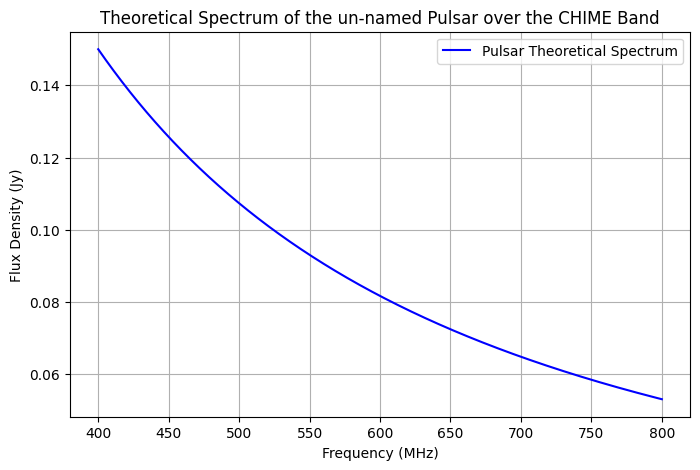

In [4]:
#Flux params of our calibrator source
alpha = -1.5
S400 = 0.15

#array of CHIME frequencies
#We go from 800 -> 400 to construct a theoretical flux array that is indexed
# in the same way. This way our theoretical flux array matches the indexing
# of the measured data set that has the frequencies in a decending order.
chime_freqs = np.linspace(400, 800, 1024)

#Calculate the theoretical flux at ehach frequency
flux_theory = theoretical_spectrum(chime_freqs, alpha, S400)

#Plot the theoretical spectrum
plt.figure(figsize=(8, 5))
plt.plot(chime_freqs, flux_theory, label='Pulsar Theoretical Spectrum', color='blue')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux Density (Jy)')
plt.title('Theoretical Spectrum of the un-named Pulsar over the CHIME Band')
plt.legend()
plt.grid(True)
plt.show()

Let's load in the Numpy array representing the average blank sky spectrum from the previous part of the project and make a plot to recall what we're working with.

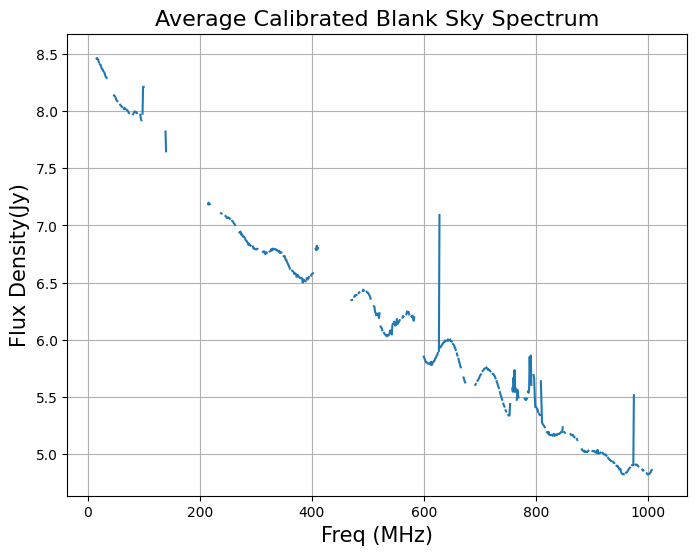

In [5]:
avg_blank_sky_spectrum = np.load('avg_blank_sky_spectrum.npy')

#Plotting average spectrum
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(avg_blank_sky_spectrum)
ax.set_title('Average Calibrated Blank Sky Spectrum', fontsize = 16)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('Flux Density(Jy)', fontsize = 15)
ax.grid(True)
plt.show()

Now, we would like to go ahead and determine the (S/N) for a single pulse using the data above. The only piece we're missing is the total number of samples being integrated. If we double check the header info for the blank sky data set, we can check the number of channels that were presumably summed over to create the average spectrum for the blank sky.

In [6]:
blank_sky_Fil = FilReader('../data/blank_sky.fil')
Pretty(blank_sky_Fil.header)

Header(
    filename='../data/blank_sky.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.34381999473,
    nsamples=30518,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (68.75000238, 45.02999878)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='../data/blank_sky.fil',
                hdrlen=414,
                datalen=125001728,
                nsamples=30518,
                tstart=60638.34381999473,
                tsamp=0.00032768
            )
        ]
    )
)

There are 30518 samples that we integrated over when producing the average spectrum, so this is the value we should take for $N$ in the (S/N) formula above.

THIS IS NOT TRUE, SINCE THE SAMPLES HERE SEEM TO BE A DIFFERENT THING THEN THE SAMPLES DEFINED BY INTEGRATING FOR EACH PULSE ETC... NEED TO THINK A BIT MORE ABOUT THIS..

In [7]:
#defining the S/N function
def signal_to_noise(S_nu, S_sys, N):
    """
    Calculates the signal to expected signal to noise given the source flux
    density and a measure of the system equivalent flux density

    Params
    ------
    S_nu
        The source flux density
    S_sys
        The system equivalent flux density
    N
        Total number of samples being integrated

    Returns
    -------
    (S/N)
        The expected signal to noise ratio given the parameters provided
    """
    return (S_nu/S_sys) * np.sqrt(N)

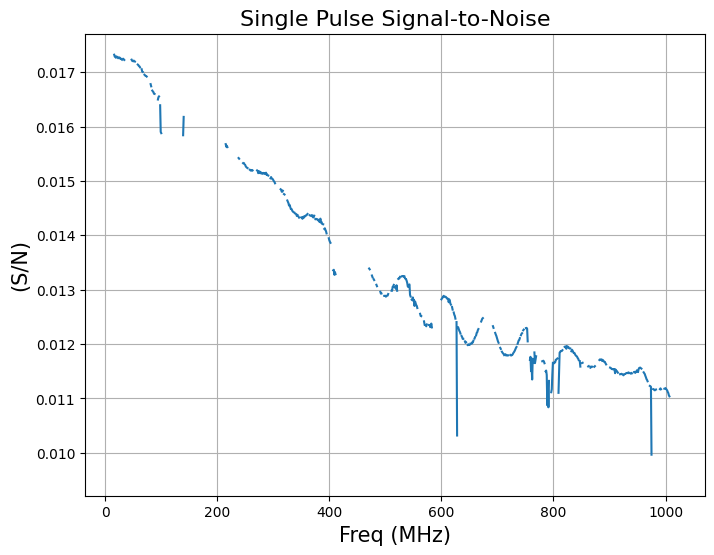

In [10]:
#using the function above, I calculate the expected signal to noise
S_nu = flux_theory
S_sys = avg_blank_sky_spectrum
N_single_pulse = 1
S_to_N_1_pulse = signal_to_noise(S_nu, S_sys, N_single_pulse)

#Plot out the expected signal to noise as a function of frequency
fig, ax = plt.subplots(figsize = (8, 6))
# ax.plot(S_to_N_1_pulse)
ax.plot(np.where(S_to_N_1_pulse == 0, np.nan, S_to_N_1_pulse))
ax.set_title('Single Pulse Signal-to-Noise', fontsize = 16)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('(S/N)', fontsize = 15)
ax.grid(True)
plt.show()

To find the expected number of integrations (ie. $N$), we can use scipy.optimize to solve for the roots when the (S/N) = 2.

At this point, there are a number of ways we could derive a value of $N$ that corresponds to a (S/N) = 2, since both $S_{\nu}$ and $S_{sys}$ are arrays spanning across all of the frequency channels. Therefore, I will determine a value for the number of folds desired to create a signal-to-noise ratio of 2 for each of the following:

1. Averaging the (S/N) across all frequency channels
2. The worst (S/N) channel
3. A value of $N$ for each of the frequency channels

N for each of these scenarios provides slightly different information that may individually come in handy when determining what is required to produce the desired signal-to-noise given exposure time.

In [9]:
from scipy.optimize import fsolve

def signal_to_noise_equals_2(N, S_nu, S_sys):
    return signal_to_noise(S_nu[1020], S_sys[1020], N) - 2

root = fsolve(signal_to_noise_equals_2, 10000, args=(S_nu, S_sys))
print(root)

[43442.20509192]
